In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# fix seed
np.random.seed(0)

In [2]:
%cd ..

/home/gb2t/Desktop/Duc/Project/GNN


## Data

In [3]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose([ #transforms.Resize(227),      # Resizes short size of the PIL image to 256
                              transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

In [4]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

# Define datasets root
DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [5]:
# concat all datasets
full_dataset = torch.utils.data.ConcatDataset([photo_dataset, art_dataset, cartoon_dataset, sketch_dataset])

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [6]:
# Create Dataloaders
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Model

In [7]:
class GCN(nn.Module):
    def __init__(self, in_features, edge_features, out_feature, device, ratio=(1,)):
        super(GCN, self).__init__()

        self.edge_net = EdgeNet(in_features=in_features,
                                num_features=edge_features,
                                device=device,
                                ratio=ratio)
        # set edge to node
        self.node_net = NodeNet(in_features=in_features,
                                num_features=out_feature,
                                device=device,
                                ratio=ratio)
        # mask value for no-gradient edges
        self.mask_val = -1

    def label2edge(self, targets):
        ''' convert node labels to affinity mask for backprop'''
        num_sample = targets.size()[1]
        label_i = targets.unsqueeze(-1).repeat(1, 1, num_sample)
        label_j = label_i.transpose(1, 2)
        edge = torch.eq(label_i, label_j).float()
        target_edge_mask = (torch.eq(label_i, self.mask_val) + torch.eq(label_j, self.mask_val)).type(torch.bool)
        source_edge_mask = ~target_edge_mask
        init_edge = edge * source_edge_mask.float()
        return init_edge[0], source_edge_mask

    def forward(self, init_node_feat):
        #  compute normalized and not normalized affinity matrix
        edge_feat, edge_sim = self.edge_net(init_node_feat)
        # compute node features and class logits
        logits_gnn = self.node_net(init_node_feat, edge_feat)
        return logits_gnn, edge_sim


class NodeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio=(1,)):
        super(NodeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        self.device = device
        # define layers
        layer_list = OrderedDict()
        for l in range(len(num_features_list)):
            layer_list['conv{}'.format(l)] = nn.Conv2d(
                in_channels=num_features_list[l - 1] if l > 0 else in_features * 2,
                out_channels=num_features_list[l],
                kernel_size=1, bias=False
            )
            layer_list['norm{}'.format(l)] = nn.BatchNorm2d(num_features=num_features_list[l])
            if l < (len(num_features_list) - 1):
                layer_list['relu{}'.format(l)] = nn.LeakyReLU()
        self.network = nn.Sequential(layer_list).to(device)

    def forward(self, node_feat, edge_feat):
        """node_feat: (bs, dim), edge_feat: (bs, bs)"""
        node_feat = node_feat.unsqueeze(dim=0) # (1, bs, dim)
        num_tasks = node_feat.size(0) # 1
        num_data = node_feat.size(1) # bs
        # get eye matrix (batch_size x node_size x node_size) only use inter dist.
        diag_mask = 1.0 - torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(self.device) # (1, bs, bs)
        # set diagonal as zero and normalize
        edge_feat = F.normalize(edge_feat * diag_mask, p=1, dim=-1) # (bs, bs)
        # compute attention and aggregate
        aggr_feat = torch.bmm(edge_feat.squeeze(1), node_feat) # (bs, dim)
        node_feat = torch.cat([node_feat, aggr_feat], -1).transpose(1, 2) # (1, 2*dim, bs)
        # non-linear transform
        node_feat = self.network(node_feat.unsqueeze(-1)).transpose(1, 2) # (1, bs, dim)
        node_feat = node_feat.squeeze(-1).squeeze(0) # (bs, dim)
        return node_feat


class EdgeNet(nn.Module):
    def __init__(self, in_features, num_features, device, ratio=(1,)):
        super(EdgeNet, self).__init__()
        num_features_list = [num_features * r for r in ratio]
        self.device = device
        # define layers
        layer_list = OrderedDict()
        for l in range(len(num_features_list)):
            layer_list['conv{}'.format(l)] = nn.Conv2d(
                in_channels=num_features_list[l - 1] if l > 0 else in_features,
                out_channels=num_features_list[l], kernel_size=1, bias=False
            )
            layer_list['norm{}'.format(l)] = nn.BatchNorm2d(num_features=num_features_list[l])
            layer_list['relu{}'.format(l)] = nn.LeakyReLU()
        # add final similarity kernel
        layer_list['conv_out'] = nn.Conv2d(in_channels=num_features_list[-1],
                                           out_channels=1, kernel_size=1)
        self.sim_network = nn.Sequential(layer_list).to(device)

    def forward(self, node_feat):
        node_feat = node_feat.unsqueeze(dim=0) # (1, bs, dim)
        num_tasks = node_feat.size(0) # 1
        num_data = node_feat.size(1) # bs
        x_i = node_feat.unsqueeze(2) # (1, bs, 1, dim)
        x_j = torch.transpose(x_i, 1, 2) # (1, 1, bs, dim)
        x_ij = torch.abs(x_i - x_j) # (1, bs, bs, dim)
        x_ij = torch.transpose(x_ij, 1, 3) # (1, dim, bs, bs)
        # compute similarity/dissimilarity (batch_size x feat_size x num_samples x num_samples)
        sim_val = torch.sigmoid(self.sim_network(x_ij)).squeeze(1).squeeze(0).to(self.device) # (bs, bs)
        # normalize affinity matrix
        force_edge_feat = torch.eye(num_data).unsqueeze(0).repeat(num_tasks, 1, 1).to(self.device) # (1, bs, bs)
        edge_feat = sim_val + force_edge_feat # (bs, bs)
        edge_feat = edge_feat + 1e-6 # add small value to avoid nan
        edge_feat = edge_feat / torch.sum(edge_feat, dim=1).unsqueeze(1) # normalize
        return edge_feat, sim_val # (bs, bs), (bs, bs)

In [8]:
# model = GCN(in_features=3, edge_features=3, out_feature=3, device=device).to(device)

# x = torch.Tensor([[1, 2, 3],
#                   [1, 2, 3.001],
#                   [3, 4, 1]]).to(device)

# # x = torch.rand(8, 2).to(device)

# out = model(x)

In [9]:
from torchvision.models import mobilenet_v3_small

class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.backbone = mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Sequential()
        
        self.gcn = GCN(in_features=576,
                        edge_features=576,
                        out_feature=num_classes, 
                        device='cuda',
                        ratio=(1,))

    def forward(self, x):
        x = self.backbone(x)
        x, edge_sim = self.gcn(x)
        return x, edge_sim

In [10]:
model = Model(num_classes=7).to(device)

/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train

In [11]:
criterion = nn.CrossEntropyLoss()
criterion_gedge = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [12]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs, edge_sim = model(images)
            # Cls loss
            loss_cls = criterion(outputs, labels)
            
            # Edge loss
            edge_gt, edge_mask = model.gcn.label2edge(labels.unsqueeze(dim=0))
            loss_edge = criterion_gedge(edge_sim.masked_select(edge_mask), edge_gt.masked_select(edge_mask))
            
            # Total loss
            loss = 0.3*loss_cls + loss_edge
        
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [13]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [14]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, edge_sim = model(inputs)
        
        # Cls loss
        loss_cls = criterion(outputs, labels)
        
        # Edge loss
        edge_gt, edge_mask = model.gcn.label2edge(labels.unsqueeze(dim=0))
        loss_edge = criterion_gedge(edge_sim.masked_select(edge_mask), edge_gt.masked_select(edge_mask))
        
        # Total loss
        loss = 0.3*loss_cls + loss_edge
                    
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):2}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.3f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [ 1/ 30] 	 Loss: 0.90354     Accuracy: 56.981% 	 Test Loss: 0.66376     Test Accuracy: 66.83%
Epoch [ 2/ 30] 	 Loss: 0.56101     Accuracy: 82.334% 	 Test Loss: 0.51354     Test Accuracy: 81.64%
Epoch [ 3/ 30] 	 Loss: 0.44563     Accuracy: 87.639% 	 Test Loss: 0.45309     Test Accuracy: 85.69%
Epoch [ 4/ 30] 	 Loss: 0.36763     Accuracy: 91.154% 	 Test Loss: 0.40244     Test Accuracy: 87.39%
Epoch [ 5/ 30] 	 Loss: 0.31153     Accuracy: 92.956% 	 Test Loss: 0.40019     Test Accuracy: 89.34%
Epoch [ 6/ 30] 	 Loss: 0.26777     Accuracy: 94.808% 	 Test Loss: 0.38200     Test Accuracy: 89.14%
Epoch [ 7/ 30] 	 Loss: 0.22735     Accuracy: 96.220% 	 Test Loss: 0.35021     Test Accuracy: 89.99%
Epoch [ 8/ 30] 	 Loss: 0.19319     Accuracy: 97.404% 	 Test Loss: 0.36303     Test Accuracy: 89.64%
Epoch [ 9/ 30] 	 Loss: 0.16813     Accuracy: 98.362% 	 Test Loss: 0.34959     Test Accuracy: 90.30%
Epoch [10/ 30] 	 Loss: 0.14522     Accuracy: 98.916% 	 Test Loss: 0.35285     Test Accuracy: 89.69%


In [15]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 28 with test accuracy: 91.35%


# Plot results

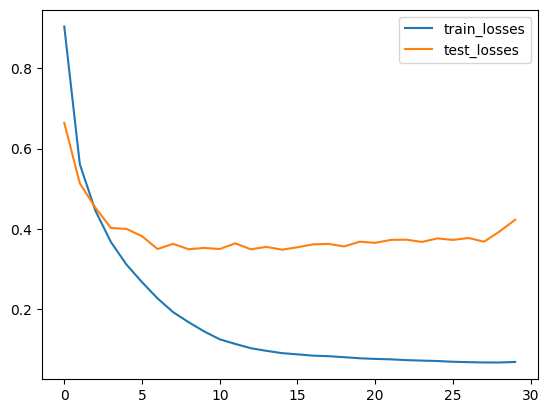

In [16]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

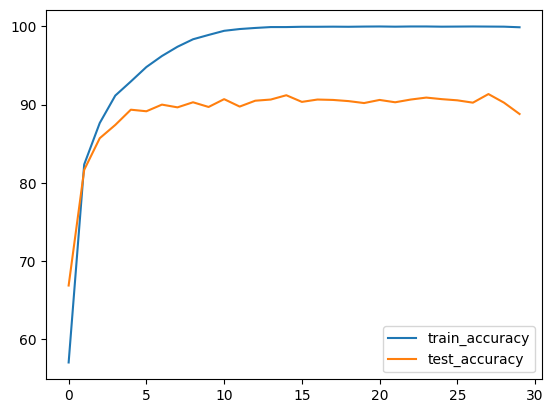

In [17]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [18]:
# save model
# torch.save(model.state_dict(), 'mobilenetv3_small.pth')